In [21]:
import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots
sns.set()
import warnings  
warnings.filterwarnings('ignore')
from itertools import product  # some useful functions
import scipy.stats as scs
from dateutil.relativedelta import relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from sklearn.model_selection import TimeSeriesSplit  # you have everything done for you 
from sklearn.model_selection import train_test_split
import datetime
from sklearn import metrics

In [22]:
df_G2 = pd.read_csv('G2.csv.xls', sep = ',') 
df_G2['date'] = df_G2['date'].map(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
# print(df_G2)
print(df_G2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    156 non-null    datetime64[ns]
 1   SO2op1  156 non-null    float64       
 2   SO2op2  156 non-null    float64       
 3   T       156 non-null    float64       
 4   SO2     156 non-null    float64       
 5   NO2     156 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 7.4 KB
None


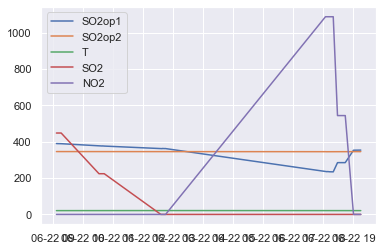

In [23]:
features = list(df_G2.columns)
features.remove('date')

plt.figure('time series')
for coll in features:
    plt.plot(df_G2.date, df_G2[coll], label = str(coll))
plt.legend(loc="best")


Подготовим данные с G2. Проводим разделение на обучение (67%) и валидацию(33%). На валидации будем сравнивать результаты моделей.

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


y = df_G2.dropna()['SO2']
X = df_G2.dropna().drop(['SO2'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33)

time_train = X_train.dropna()['date']
X_train = X_train.drop(['date'], axis=1)
time_valid = X_valid.dropna()['date']
X_valid = X_valid.drop(['date'], axis=1)


X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid))
list_X = X_train.columns.values.tolist()
X_train_scaled.set_axis(list_X, axis = 'columns', inplace=True)
X_valid_scaled.set_axis(list_X, axis = 'columns', inplace=True)


print(X_train_scaled)



       SO2op1    SO2op2         T       NO2
0    0.657762  0.717488  1.957783 -0.767199
1    0.904290  0.772066  1.478684 -0.767199
2    0.510079  0.373648 -0.437712 -0.767199
3    0.664579  0.679284  1.957783 -0.767199
4    1.105406  0.954902 -0.437712 -0.767199
..        ...       ...       ...       ...
99   0.661989  1.612564  1.957783 -0.767199
100  0.509060  0.671097 -0.437712 -0.767199
101  0.511967  0.231746 -0.200079 -0.767199
102  0.509294  0.444599 -0.437712 -0.767199
103 -1.473942 -1.451980 -0.675345  1.579528

[104 rows x 4 columns]


In [25]:
def plotCoefficients(model, X_train = X_train, stringg = ""):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed")
    plt.title(stringg)
    
def print_metrics(model, X_train = X_train_scaled, X_valid = X_valid_scaled,\
                  y_train = y_train, y_valid = y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print('Scor  \t train \t valid')
    print('MAE  \t', round(metrics.mean_absolute_error(y_train,y_train_pred),1),\
          '\t', round(metrics.mean_absolute_error(y_valid,y_valid_pred),1))
    print('MSE  \t', round(metrics.mean_squared_error(y_train,y_train_pred)),\
          '\t', round(metrics.mean_squared_error(y_valid,y_valid_pred)))
    print('R2   \t', round(metrics.r2_score(y_train,y_train_pred),3),\
          '\t', round(metrics.r2_score(y_valid,y_valid_pred),3))    

In [26]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(X_train_scaled, y_train)
# plotCoefficients(mlr, X_train_scaled, "Coefficients MLR")
print_metrics(mlr)

Scor  	 train 	 valid
MAE  	 24.3 	 31.7
MSE  	 857 	 1284
R2   	 0.97 	 0.922


Результаты на тренировке и валидации близкии к друг другу.
Будем смотреть сразу на несколько метрик

Также анализ для L1,L2 регрессии. Используем кроссвалидацию на тесте для поиска гиперпараметра регуляризации.

In [27]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.2)

lasso = LassoCV(alphas = [ 0.0001, 0.0003, 0.001, 0.003, 0.01,\
                          0.03, 0.1, 0.3, 1, 3,10, 30, 100], cv=ss)
lasso.fit(X_train_scaled, y_train)
# plotCoefficients(lasso, X_train_scaled, "Coefficients Lasso")
print_metrics(lasso)

Scor  	 train 	 valid
MAE  	 24.8 	 32.1
MSE  	 866 	 1259
R2   	 0.97 	 0.924


In [28]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas = [ 0.0001, 0.0003, 0.001, 0.003, 0.01,\
                          0.03, 0.1, 0.3, 1, 3,10, 30, 100], cv=ss)
ridge.fit(X_train_scaled, y_train)
# plotCoefficients(ridge, X_train_scaled, "Coefficients Ridge")
print_metrics(ridge)

Scor  	 train 	 valid
MAE  	 24.3 	 31.7
MSE  	 857 	 1284
R2   	 0.97 	 0.922


$$\bf Прогнозирование\ на\ тесте$$

In [29]:
df_test = pd.read_csv('test.csv.xls', sep = ',') 
df_test['date'] = df_test['date'].map(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
# print(df_test)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    864 non-null    datetime64[ns]
 1   SO2op1  864 non-null    float64       
 2   SO2op2  864 non-null    float64       
 3   T       864 non-null    float64       
 4   NO2     864 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 33.9 KB
None


In [30]:
time_test = df_test.dropna()['date']
X_test = df_test.drop(['date'], axis=1)

X_test_scaled = pd.DataFrame(scaler.transform(X_test))

list_X = X_train.columns.values.tolist()
X_test_scaled.set_axis(list_X, axis = 'columns', inplace=True)

print(X_test_scaled)

def plot_test_SO2(model, time = time_test, X = X_test_scaled, cl = 'black', st = 'model'):
    plt.plot(time, model.predict(X).flatten(), color = cl, label = st)



       SO2op1    SO2op2          T       NO2
0    0.417516 -1.713953 -84.989100 -0.673489
1    0.419187 -2.559909 -84.989100 -0.669071
2    0.416848 -2.696354 -84.490837 -0.669062
3    0.416848 -2.478043 -84.030902 -0.674780
4    0.420858 -1.877687 -83.570967 -0.674710
..        ...       ...        ...       ...
859  0.429713 -0.213063 -79.239912 -0.683854
860  0.433556 -0.513241 -79.508207 -0.683854
861  0.434391  0.441870 -79.239912 -0.682980
862  0.430883 -0.513241 -79.239912 -0.681958
863  0.422528 -1.522931 -79.239912 -0.681797

[864 rows x 4 columns]


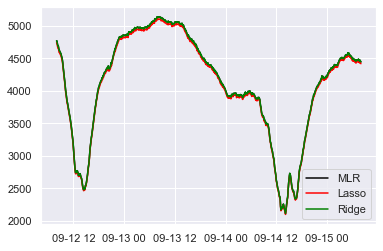

In [31]:
plt.figure("MLR Results")
plot_test_SO2(mlr, cl = 'black', st = 'MLR')
plot_test_SO2(lasso, cl = 'red', st = 'Lasso')
plot_test_SO2(ridge, cl = 'green', st = 'Ridge')
plt.legend(loc="best")

Все модели близки к друг другу.

$$\bf MLR\ на\ всём\ G2$$

In [32]:
time = X.dropna()['date']
X_all_train = X.drop(['date'], axis=1)

X_all_train_scaled = pd.DataFrame(scaler.fit_transform(X_all_train))
X_all_test_scaled = pd.DataFrame(scaler.transform(X_test))


X_all_train_scaled.set_axis(list_X, axis = 'columns', inplace=True)
print(X_all_train_scaled)

mlr_all = LinearRegression()
mlr_all.fit(X_all_train_scaled, y)


y_all_pred = mlr_all.predict(X_all_train_scaled)
print('Scor  \t train')
print('MAE  \t', round(metrics.mean_absolute_error(y,y_all_pred),1))
print('MSE  \t', round(metrics.mean_squared_error(y,y_all_pred)))
print('R2   \t', round(metrics.r2_score(y,y_all_pred),3))



       SO2op1    SO2op2         T       NO2
0    1.152797  0.468463 -0.675991 -0.765092
1    1.160780  1.262037 -0.448979 -0.765092
2    1.160780  1.262037 -0.675991 -0.765092
3    1.151056  0.865250 -0.448979 -0.765092
4    1.151056  0.865250 -0.448979 -0.765092
..        ...       ...       ...       ...
151  0.522738 -0.739026 -0.221966 -0.765092
152  0.520241  0.534118 -0.221966 -0.765092
153  0.520241  0.534118 -0.448979 -0.765092
154  0.522140  0.782467 -0.221966 -0.765092
155  0.522140  0.782467 -0.221966 -0.765092

[156 rows x 4 columns]
Scor  	 train
MAE  	 27.5
MSE  	 978
R2   	 0.961


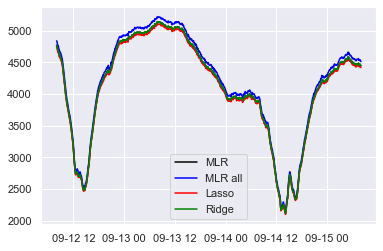

In [33]:
plt.figure("MLR Results")
plot_test_SO2(mlr, X = X_test_scaled, cl = 'black', st = 'MLR')
plot_test_SO2(mlr_all, X = X_all_test_scaled, cl = 'blue', st = 'MLR all')
plot_test_SO2(lasso, X = X_test_scaled, cl = 'red', st = 'Lasso')
plot_test_SO2(ridge, X = X_test_scaled, cl = 'green', st = 'Ridge')
plt.legend(loc="best")

Проведём анализ ошибок на тесте и валидации для наших моделей. 

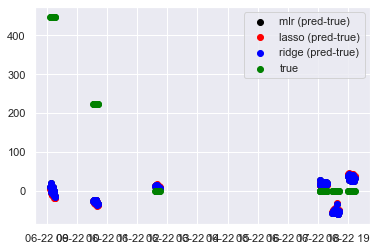

In [34]:
plt.figure()
plt.scatter(time_train, mlr.predict(X_train_scaled) - y_train, color = 'black', label = 'mlr (pred-true)')
plt.scatter(time_train, lasso.predict(X_train_scaled) - y_train, color = 'red', label = 'lasso (pred-true)')
plt.scatter(time_train, ridge.predict(X_train_scaled) - y_train, color = 'blue', label = 'ridge (pred-true)')
plt.scatter(time_train, y_train, color = 'green', label = 'true')
plt.legend(loc="best")

Как видим модель MLR сильно ошибается на низких концентрациях. (Было показано и ранее в работах)

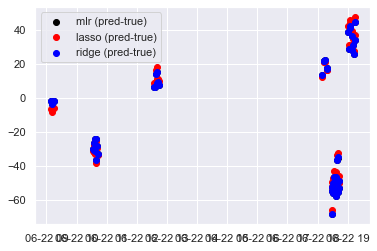

In [35]:
plt.figure()
plt.scatter(time_valid, mlr.predict(X_valid_scaled) - y_valid, color = 'black', label = 'mlr (pred-true)')
plt.scatter(time_valid, lasso.predict(X_valid_scaled) - y_valid, color = 'red', label = 'lasso (pred-true)')
plt.scatter(time_valid, ridge.predict(X_valid_scaled) - y_valid, color = 'blue', label = 'ridge (pred-true)')
# plt.scatter(time_train, y_train, color = 'green', label = 'true')
plt.legend(loc="best")

Сравним данные с G2 и данные с test. Воспользуемся корреляционным анализом. 
Построим диаграммы корреляции Пирсона. 

<AxesSubplot:>

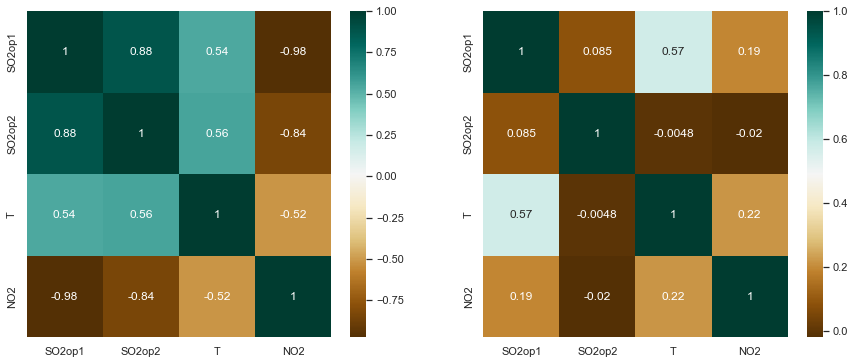

In [36]:
features_test = list(df_test.columns)
features_test.remove('date')

fig = plt.figure()
fig.set_size_inches(15, 6)
ax1 = fig.add_subplot(121)
c_m_pear_G2 = df_G2[features_test].corr(method='pearson')
sns.heatmap(c_m_pear_G2, annot=True, cmap = 'BrBG')

ax2 = fig.add_subplot(122)
c_m_pear_test = df_test[features_test].corr(method='pearson')
sns.heatmap(c_m_pear_test, annot=True, cmap = 'BrBG')


Сравнение корреляционных диаграмм для тренировочного набора данных (G2) и тестового (test):
    
    1) В Полевых испытаниях в отличие от лабораторных 
    практически остутсвует линейная зависимость м/у электродами op1,op2
    2) Влияние T на op1 то же, в отличие от T на op2
    3) NO2 значительно в меньшей степени влияет на показания op1 и op2 в пол.исп
    
Это говорит о необходимости калибровки в полевых испытаниях,

данные собранные в лаборатории отличаются от данных собранных в пол. исп.    

Исходя из корреляционной матрицы для лаборатрных испытаний: 

1) Положительная линейная зависимость между показаниями электродов

2) Отрицательная линейная зависимость между пок. элект. и N02

3) Слабая линнейная зависимость от температуры

4) Слабая положительная зависимость м/у показаниями элект. и SO2

Кроме этого измерения SO2 в лаборатории проводились для трёх различных значений концентраций SO2. Это может оказаться недостаточным для калибровки и дальнейшего использования в полевых исспытаниях.